<a href="https://colab.research.google.com/github/wavatatarskii/TatarDLTranslationTechniques/blob/master/examples/test/Tatar_RussianDLTranslationTechnique_Transformer_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install the nightly built Tensorflow 2.0 to use LayerNorm layer

In [2]:
!git clone https://github.com/wavatatarskii/TatarDLTranslationTechniques.git

Cloning into 'TatarDLTranslationTechniques'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [0]:
# !pip install tensorflow-gpu==2.0.0-alpha
!pip install tf-nightly-gpu-2.0-preview

### Import and create utility functions

In [3]:
import tensorflow as tf
import numpy as np
import unicodedata
import re
import os
import requests
from zipfile import ZipFile
import time
tf.compat.v1.enable_eager_execution()

# Mode can be either 'train' or 'infer'
# Set to 'infer' will skip the training
MODE = 'train'
# URL = 'http://www.manythings.org/anki/fra-eng.zip'
#URL = 'http://www.manythings.org/anki/ita-eng.zip'
FILENAME = '/content/TatarDLTranslationTechniques/tatTABru60000-1.zip'


def maybe_download_and_read_file(url, filename):
    """ Download and unzip training data
    Args:
        url: data url
        filename: zip filename
    
    Returns:
        Training data: an array containing text lines from the data
    """
    if not os.path.exists(filename):
        session = requests.Session()
        response = session.get(url, stream=True)

        CHUNK_SIZE = 32768
        with open(filename, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:
                    f.write(chunk)

    zipf = ZipFile(filename)
    filename = zipf.namelist()
    with zipf.open(filename[0]) as f:
        lines = f.read()

    return lines






def normalize_string(s):
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'\s+', r' ', s)
    return s

### Download and process training data

In [4]:
lines = maybe_download_and_read_file(None, FILENAME)
lines = lines.decode('utf-8')

raw_data = []
for line in lines.split('\n'):
    raw_data.append(line.split('\t'))

print(raw_data[-5:])
# The last element is empty, so omit it
raw_data = raw_data[:-1]


"""## Preprocessing"""



raw_data_tt, raw_data_ru = list(zip(*raw_data))
raw_data_tt = [normalize_string(data) for data in raw_data_tt]
raw_data_ru_in = ['<start> ' + normalize_string(data) for data in raw_data_ru]
raw_data_ru_out = [normalize_string(data) + ' <end>' for data in raw_data_ru]

"""## Tokenization"""

tt_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tt_tokenizer.fit_on_texts(raw_data_tt)
data_tt = tt_tokenizer.texts_to_sequences(raw_data_tt)
data_tt = tf.keras.preprocessing.sequence.pad_sequences(data_tt,
                                                        padding='post')

ru_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
ru_tokenizer.fit_on_texts(raw_data_ru_in)
ru_tokenizer.fit_on_texts(raw_data_ru_out)
data_ru_in = ru_tokenizer.texts_to_sequences(raw_data_ru_in)
data_ru_in = tf.keras.preprocessing.sequence.pad_sequences(data_ru_in,
                                                           padding='post')

data_ru_out = ru_tokenizer.texts_to_sequences(raw_data_ru_out)
data_ru_out = tf.keras.preprocessing.sequence.pad_sequences(data_ru_out,
                                                            padding='post')

"""## Create tf.data.Dataset object"""

BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices(
    (data_tt, data_ru_in, data_ru_out))
dataset = dataset.shuffle(len(data_tt)).batch(BATCH_SIZE)

[['Болай да артыгын сөйләдем.', 'Я и так изложил.\r'], ['Рәхмәт, Мәннән абзый.', 'Спасибо, Майдан-абзый.\r'], ['Сау бул, кызым.', 'До свидания, дочка.\r'], ['Ана теләге дәрья төбеннән чыгарыр, диләр бит.', 'Говорят же, что желание матери выведет ее из дна.\r'], ['Йоклаганга салышып, тын гына ята бирде.', 'Молча лежал, притворившись спящим.']]


### Positional Encoding

In [5]:
"""## Create the Positional Embedding"""


def positional_encoding(pos, model_size):
    """ Compute positional encoding for a particular position
    Args:
        pos: position of a token in the sequence
        model_size: depth size of the model
    
    Returns:
        The positional encoding for the given token
    """
    PE = np.zeros((1, model_size))
    for i in range(model_size):
        if i % 2 == 0:
            PE[:, i] = np.sin(pos / 10000 ** (i / model_size))
        else:
            PE[:, i] = np.cos(pos / 10000 ** ((i - 1) / model_size))
    return PE

max_length = max(len(data_tt[0]), len(data_ru_in[0]))
MODEL_SIZE = 128

pes = []
for i in range(max_length):
    pes.append(positional_encoding(i, MODEL_SIZE))

pes = np.concatenate(pes, axis=0)
pes = tf.constant(pes, dtype=tf.float32)


print(pes.shape)
print(data_tt.shape)
print(data_ru_in.shape)

(98, 128)
(59734, 98)
(59734, 90)


### Multi-Head Attention layer

In [0]:
"""## Create the Multihead Attention layer"""


class MultiHeadAttention(tf.keras.Model):
    """ Class for Multi-Head Attention layer
    Attributes:
        key_size: d_key in the paper
        h: number of attention heads
        wq: the Linear layer for Q
        wk: the Linear layer for K
        wv: the Linear layer for V
        wo: the Linear layer for the output
    """
    def __init__(self, model_size, h):
        super(MultiHeadAttention, self).__init__()
        self.key_size = model_size // h
        self.h = h
        self.wq = tf.keras.layers.Dense(model_size) #[tf.keras.layers.Dense(key_size) for _ in range(h)]
        self.wk = tf.keras.layers.Dense(model_size) #[tf.keras.layers.Dense(key_size) for _ in range(h)]
        self.wv = tf.keras.layers.Dense(model_size) #[tf.keras.layers.Dense(value_size) for _ in range(h)]
        self.wo = tf.keras.layers.Dense(model_size)

    def call(self, query, value, mask=None):
        """ The forward pass for Multi-Head Attention layer
        Args:
            query: the Q matrix
            value: the V matrix, acts as V and K
            mask: mask to filter out unwanted tokens
                  - zero mask: mask for padded tokens
                  - right-side mask: mask to prevent attention towards tokens on the right-hand side
        
        Returns:
            The concatenated context vector
            The alignment (attention) vectors of all heads
        """
        # query has shape (batch, query_len, model_size)
        # value has shape (batch, value_len, model_size)
        query = self.wq(query)
        key = self.wk(value)
        value = self.wv(value)
        
        # Split matrices for multi-heads attention
        batch_size = query.shape[0]
        
        # Originally, query has shape (batch, query_len, model_size)
        # We need to reshape to (batch, query_len, h, key_size)
        query = tf.reshape(query, [batch_size, -1, self.h, self.key_size])
        # In order to compute matmul, the dimensions must be transposed to (batch, h, query_len, key_size)
        query = tf.transpose(query, [0, 2, 1, 3])
        
        # Do the same for key and value
        key = tf.reshape(key, [batch_size, -1, self.h, self.key_size])
        key = tf.transpose(key, [0, 2, 1, 3])
        value = tf.reshape(value, [batch_size, -1, self.h, self.key_size])
        value = tf.transpose(value, [0, 2, 1, 3])
        
        # Compute the dot score
        # and divide the score by square root of key_size (as stated in paper)
        # (must convert key_size to float32 otherwise an error would occur)
        score = tf.matmul(query, key, transpose_b=True) / tf.math.sqrt(tf.dtypes.cast(self.key_size, dtype=tf.float32))
        # score will have shape of (batch, h, query_len, value_len)
        
        # Mask out the score if a mask is provided
        # There are two types of mask:
        # - Padding mask (batch, 1, 1, value_len): to prevent attention being drawn to padded token (i.e. 0)
        # - Look-left mask (batch, 1, query_len, value_len): to prevent decoder to draw attention to tokens to the right
        if mask is not None:
            score *= mask

            # We want the masked out values to be zeros when applying softmax
            # One way to accomplish that is assign them to a very large negative value
            score = tf.where(tf.equal(score, 0), tf.ones_like(score) * -1e9, score)
        
        # Alignment vector: (batch, h, query_len, value_len)
        alignment = tf.nn.softmax(score, axis=-1)
        
        # Context vector: (batch, h, query_len, key_size)
        context = tf.matmul(alignment, value)
        
        # Finally, do the opposite to have a tensor of shape (batch, query_len, model_size)
        context = tf.transpose(context, [0, 2, 1, 3])
        context = tf.reshape(context, [batch_size, -1, self.key_size * self.h])
        
        # Apply one last full connected layer (WO)
        heads = self.wo(context)
        
        return heads, alignment

### The Encoder

In [0]:
"""## Create the Encoder"""


class Encoder(tf.keras.Model):
    """ Class for the Encoder
    Args:
        model_size: d_model in the paper (depth size of the model)
        num_layers: number of layers (Multi-Head Attention + FNN)
        h: number of attention heads
        embedding: Embedding layer
        embedding_dropout: Dropout layer for Embedding
        attention: array of Multi-Head Attention layers
        attention_dropout: array of Dropout layers for Multi-Head Attention
        attention_norm: array of LayerNorm layers for Multi-Head Attention
        dense_1: array of first Dense layers for FFN
        dense_2: array of second Dense layers for FFN
        ffn_dropout: array of Dropout layers for FFN
        ffn_norm: array of LayerNorm layers for FFN
    """
    def __init__(self, vocab_size, model_size, num_layers, h):
        super(Encoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        self.embedding = tf.keras.layers.Embedding(vocab_size, model_size)
        self.embedding_dropout = tf.keras.layers.Dropout(0.1)
        self.attention = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_dropout = [tf.keras.layers.Dropout(0.1) for _ in range(num_layers)]

        self.attention_norm = [tf.keras.layers.LayerNormalization(
            epsilon=1e-6) for _ in range(num_layers)]

        self.dense_1 = [tf.keras.layers.Dense(
            MODEL_SIZE * 4, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(
            model_size) for _ in range(num_layers)]
        self.ffn_dropout = [tf.keras.layers.Dropout(0.1) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.LayerNormalization(
            epsilon=1e-6) for _ in range(num_layers)]

    def call(self, sequence, training=True, encoder_mask=None):
        """ Forward pass for the Encoder
        Args:
            sequence: source input sequences
            training: whether training or not (for Dropout)
            encoder_mask: padding mask for the Encoder's Multi-Head Attention
        
        Returns:
            The output of the Encoder (batch_size, length, model_size)
            The alignment (attention) vectors for all layers
        """
        embed_out = self.embedding(sequence)

        embed_out *= tf.math.sqrt(tf.cast(self.model_size, tf.float32))
        embed_out += pes[:sequence.shape[1], :]
        embed_out = self.embedding_dropout(embed_out)

        sub_in = embed_out
        alignments = []

        for i in range(self.num_layers):
            sub_out, alignment = self.attention[i](sub_in, sub_in, encoder_mask)
            sub_out = self.attention_dropout[i](sub_out, training=training)
            sub_out = sub_in + sub_out
            sub_out = self.attention_norm[i](sub_out)
            
            alignments.append(alignment)
            ffn_in = sub_out

            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            ffn_out = self.ffn_dropout[i](ffn_out, training=training)
            ffn_out = ffn_in + ffn_out
            ffn_out = self.ffn_norm[i](ffn_out)

            sub_in = ffn_out

        return ffn_out, alignments

### Create an instance of the Encoder

In [8]:
H = 8
NUM_LAYERS = 4
vocab_size = len(tt_tokenizer.word_index) + 1
encoder = Encoder(vocab_size, MODEL_SIZE, NUM_LAYERS, H)
print(vocab_size)
sequence_in = tf.constant([[1, 2, 3, 0, 0]])
encoder_output, _ = encoder(sequence_in)
encoder_output.shape

72060


TensorShape([Dimension(1), Dimension(5), Dimension(128)])

### The Decoder

In [0]:
class Decoder(tf.keras.Model):
    """ Class for the Decoder
    Args:
        model_size: d_model in the paper (depth size of the model)
        num_layers: number of layers (Multi-Head Attention + FNN)
        h: number of attention heads
        embedding: Embedding layer
        embedding_dropout: Dropout layer for Embedding
        attention_bot: array of bottom Multi-Head Attention layers (self attention)
        attention_bot_dropout: array of Dropout layers for bottom Multi-Head Attention
        attention_bot_norm: array of LayerNorm layers for bottom Multi-Head Attention
        attention_mid: array of middle Multi-Head Attention layers
        attention_mid_dropout: array of Dropout layers for middle Multi-Head Attention
        attention_mid_norm: array of LayerNorm layers for middle Multi-Head Attention
        dense_1: array of first Dense layers for FFN
        dense_2: array of second Dense layers for FFN
        ffn_dropout: array of Dropout layers for FFN
        ffn_norm: array of LayerNorm layers for FFN
        dense: Dense layer to compute final output
    """
    def __init__(self, vocab_size, model_size, num_layers, h):
        super(Decoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        self.embedding = tf.keras.layers.Embedding(vocab_size, model_size)
        self.embedding_dropout = tf.keras.layers.Dropout(0.1)
        self.attention_bot = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_bot_dropout = [tf.keras.layers.Dropout(0.1) for _ in range(num_layers)]
        self.attention_bot_norm = [tf.keras.layers.LayerNormalization(
            epsilon=1e-6) for _ in range(num_layers)]
        self.attention_mid = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_mid_dropout = [tf.keras.layers.Dropout(0.1) for _ in range(num_layers)]
        self.attention_mid_norm = [tf.keras.layers.LayerNormalization(
            epsilon=1e-6) for _ in range(num_layers)]

        self.dense_1 = [tf.keras.layers.Dense(
            MODEL_SIZE * 4, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(
            model_size) for _ in range(num_layers)]
        self.ffn_dropout = [tf.keras.layers.Dropout(0.1) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.LayerNormalization(
            epsilon=1e-6) for _ in range(num_layers)]

        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, sequence, encoder_output, training=True, encoder_mask=None):
        """ Forward pass for the Decoder
        Args:
            sequence: source input sequences
            encoder_output: output of the Encoder (for computing middle attention)
            training: whether training or not (for Dropout)
            encoder_mask: padding mask for the Encoder's Multi-Head Attention
        
        Returns:
            The output of the Encoder (batch_size, length, model_size)
            The bottom alignment (attention) vectors for all layers
            The middle alignment (attention) vectors for all layers
        """
        # EMBEDDING AND POSITIONAL EMBEDDING
        embed_out = self.embedding(sequence)

        embed_out *= tf.math.sqrt(tf.cast(self.model_size, tf.float32))
        embed_out += pes[:sequence.shape[1], :]
        embed_out = self.embedding_dropout(embed_out)

        bot_sub_in = embed_out
        bot_alignments = []
        mid_alignments = []

        for i in range(self.num_layers):
            # BOTTOM MULTIHEAD SUB LAYER
            seq_len = bot_sub_in.shape[1]

            if training:
                mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
            else:
                mask = None
            bot_sub_out, bot_alignment = self.attention_bot[i](bot_sub_in, bot_sub_in, mask)
            bot_sub_out = self.attention_bot_dropout[i](bot_sub_out, training=training)
            bot_sub_out = bot_sub_in + bot_sub_out
            bot_sub_out = self.attention_bot_norm[i](bot_sub_out)
            
            bot_alignments.append(bot_alignment)

            # MIDDLE MULTIHEAD SUB LAYER
            mid_sub_in = bot_sub_out

            mid_sub_out, mid_alignment = self.attention_mid[i](
                mid_sub_in, encoder_output, encoder_mask)
            mid_sub_out = self.attention_mid_dropout[i](mid_sub_out, training=training)
            mid_sub_out = mid_sub_out + mid_sub_in
            mid_sub_out = self.attention_mid_norm[i](mid_sub_out)
            
            mid_alignments.append(mid_alignment)

            # FFN
            ffn_in = mid_sub_out

            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            ffn_out = self.ffn_dropout[i](ffn_out, training=training)
            ffn_out = ffn_out + ffn_in
            ffn_out = self.ffn_norm[i](ffn_out)

            bot_sub_in = ffn_out

        logits = self.dense(ffn_out)

        return logits, bot_alignments, mid_alignments

### Create an instance of the Decoder

In [10]:
vocab_size = len(ru_tokenizer.word_index) + 1
decoder = Decoder(vocab_size, MODEL_SIZE, NUM_LAYERS, H)

sequence_in = tf.constant([[14, 24, 31, 0, 0]])
decoder_output, _, _ = decoder(sequence_in, encoder_output)
decoder_output.shape

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


TensorShape([Dimension(1), Dimension(5), Dimension(64643)])

### Loss function

In [0]:
crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)


def loss_func(targets, logits):
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

### Learning rate scheduling and optimization

In [0]:
class WarmupThenDecaySchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """ Learning schedule for training the Transformer
    Attributes:
        model_size: d_model in the paper (depth size of the model)
        warmup_steps: number of warmup steps at the beginning
    """
    def __init__(self, model_size, warmup_steps=4000):
        super(WarmupThenDecaySchedule, self).__init__()

        self.model_size = model_size
        self.model_size = tf.cast(self.model_size, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step_term = tf.math.rsqrt(step)
        warmup_term = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.model_size) * tf.math.minimum(step_term, warmup_term)


lr = WarmupThenDecaySchedule(MODEL_SIZE)
optimizer = tf.keras.optimizers.Adam(lr,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

### The predict function

In [0]:
def predict(test_source_text=None):
    """ Predict the output sentence for a given input sentence
    Args:
        test_source_text: input sentence (raw string)
    
    Returns:
        The encoder's attention vectors
        The decoder's bottom attention vectors
        The decoder's middle attention vectors
        The input string array (input sentence split by ' ')
        The output string array
    """
    if test_source_text is None:
        test_source_text = raw_data_tt[np.random.choice(len(raw_data_tt))]
    print(test_source_text)
    test_source_seq = tt_tokenizer.texts_to_sequences([test_source_text])
    print(test_source_seq)

    en_output, en_alignments = encoder(tf.constant(test_source_seq), training=False)

    de_input = tf.constant(
        [[ru_tokenizer.word_index['<start>']]], dtype=tf.int64)

    out_words = []

    while True:
        de_output, de_bot_alignments, de_mid_alignments = decoder(de_input, en_output, training=False)
        new_word = tf.expand_dims(tf.argmax(de_output, -1)[:, -1], axis=1)
        out_words.append(ru_tokenizer.index_word[new_word.numpy()[0][0]])

        # Transformer doesn't have sequential mechanism (i.e. states)
        # so we have to add the last predicted word to create a new input sequence
        de_input = tf.concat((de_input, new_word), axis=-1)

        # TODO: get a nicer constraint for the sequence length!
        if out_words[-1] == '<end>' or len(out_words) >= 14:
            break

    print(' '.join(out_words))
    return en_alignments, de_bot_alignments, de_mid_alignments, test_source_text.split(' '), out_words

### The train_step function

In [0]:
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out):
    """ Execute one training step (forward pass + backward pass)
    Args:
        source_seq: source sequences
        target_seq_in: input target sequences (<start> + ...)
        target_seq_out: output target sequences (... + <end>)
    
    Returns:
        The loss value of the current pass
    """
    with tf.GradientTape() as tape:
        encoder_mask = 1 - tf.cast(tf.equal(source_seq, 0), dtype=tf.float32)
        # encoder_mask has shape (batch_size, source_len)
        # we need to add two more dimensions in between
        # to make it broadcastable when computing attention heads
        encoder_mask = tf.expand_dims(encoder_mask, axis=1)
        encoder_mask = tf.expand_dims(encoder_mask, axis=1)
        encoder_output, _ = encoder(source_seq, encoder_mask=encoder_mask)

        decoder_output, _, _ = decoder(
            target_seq_in, encoder_output, encoder_mask=encoder_mask)

        loss = loss_func(target_seq_out, decoder_output)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

### The training loop

In [43]:
NUM_EPOCHS = 35
import pandas as pd
starttime = time.time()
for e in range(NUM_EPOCHS):
    for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
        loss = train_step(source_seq, target_seq_in,
                          target_seq_out)
        if batch % 60 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Elapsed time {:.2f}s'.format(
                e + 1, batch, loss.numpy(), time.time() - starttime))
            starttime = time.time()
            table = pd.DataFrame(index=time.time(), columns= ['Loss'])

    try:
        predict()
    except Exception as e:
        print(e)
        continue

Epoch 1 Batch 0 Loss 1.0140 Elapsed time 0.57s
Epoch 1 Batch 60 Loss 0.9570 Elapsed time 25.63s
Epoch 1 Batch 120 Loss 0.8968 Elapsed time 25.93s
Epoch 1 Batch 180 Loss 0.8501 Elapsed time 25.52s
Epoch 1 Batch 240 Loss 0.7644 Elapsed time 25.50s
Epoch 1 Batch 300 Loss 0.9342 Elapsed time 25.60s
Epoch 1 Batch 360 Loss 0.8236 Elapsed time 25.60s
Epoch 1 Batch 420 Loss 0.7742 Elapsed time 25.59s
Epoch 1 Batch 480 Loss 0.8510 Elapsed time 25.55s
Epoch 1 Batch 540 Loss 0.8630 Elapsed time 25.69s
Epoch 1 Batch 600 Loss 0.7614 Elapsed time 25.63s
Epoch 1 Batch 660 Loss 0.8535 Elapsed time 25.66s
Epoch 1 Batch 720 Loss 0.6867 Elapsed time 25.61s
Epoch 1 Batch 780 Loss 0.8249 Elapsed time 25.67s
Epoch 1 Batch 840 Loss 0.7739 Elapsed time 25.66s
Epoch 1 Batch 900 Loss 0.7445 Elapsed time 25.66s
Яңа елны быел бездә каршы алабыз дип .
[[108, 1683, 1484, 677, 141, 3285, 12, 1]]
он не было не было . <end>
Epoch 2 Batch 0 Loss 0.7774 Elapsed time 19.91s
Epoch 2 Batch 60 Loss 0.7841 Elapsed time 25.62

In [19]:
test_sents = (
    "Ә чынында исә, кеше түгел, гөмбә ул!",
    "Андагы пулемет һәм автомат тавышлары монда бик тонык ишетелә.",
    "Озак та үтмәде, күбәләк-күбәләк кар ява башлады.",
    "Күк йөзе, авыр болытлардан әкрен-әкрен генә арчылып, зәңгәр күл сыман, урман өстенә җәелде.",
    "Меңнәрчә, миллионнарча кар энҗеләре җем-җем итеп балкыйлар.",
    "Барыбыз да ул күрсәткән якка борылдык.",
    "Шуннан соң без аның турында һичнәрсә ишетмәдек.",
    "Аның тавышында мин бүгенгә кадәр һич тә ишетмәгән әллә нинди сагыш, әрнү сиздем һәм үземнең бу саксыз-лыгым өчен аңардан гафу үтендем.",
    "Дөресен әйткәндә, сез икенче тапкыр дөньяга тудыгыз.",
    "Ә Хәйбулланың үле гәүдәсе дә юк, бары тик бүреге һәм каскасы гына төшеп калган иде.",
    "Сугышчылар, коралларына тотынып, тын да алмыйча көтә башладылар.",
)


for i, test_sent in enumerate(test_sents):
    test_sequence = normalize_string(test_sent)
    predict(test_sequence)

Ә чынында исә, кеше түгел, гөмбә ул !
[[17, 6101, 3205, 25, 62, 11695, 3, 9]]
предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета
Андагы пулемет һәм автомат тавышлары монда бик тонык ишетелә .
[[1552, 20203, 14, 4417, 1455, 88, 16, 1848, 938, 1]]
предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета
Озак та үтмәде, күбәләк-күбәләк кар ява башлады .
[[190, 63, 3694, 20204, 409, 2810, 73, 1]]
предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета
Күк йөзе, авыр болытлардан әкрен-әкрен генә арчылып, зәңгәр күл сыман, урман өстенә җәелде .
[[564, 3198, 182, 10528, 3697, 13, 20212, 487, 984, 889, 966, 183, 12462, 1]]
предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета
Меңнәрчә, миллионнарча кар энҗеләре җ

### Infer using 20 training examples

### Infer on a random example

In [20]:
en_alignments, de_bot_alignments, de_mid_alignments, source, prediction = predict()

Малайлар да, Гүзәл дә шактый артта калдылар .
[[1468, 26, 1587, 5, 156, 2124, 1148, 1]]
предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета предмета


### Examine Encoder's attention

(8, 8)


[Text(0, 0, ''),
 Text(0, 0, 'Чөнки'),
 Text(0, 0, 'дөнья'),
 Text(0, 0, 'гыйлеме'),
 Text(0, 0, 'тупланган'),
 Text(0, 0, 'башка'),
 Text(0, 0, 'җир'),
 Text(0, 0, 'юк'),
 Text(0, 0, '.')]

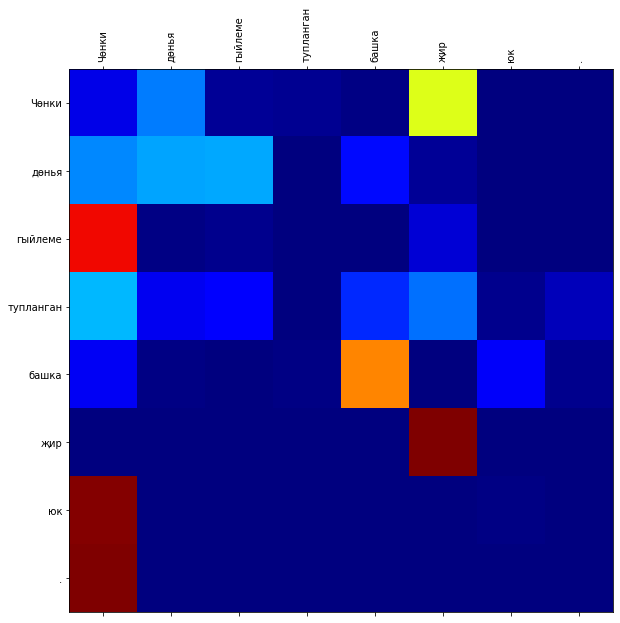

In [59]:
# attention = tf.reduce_mean(de_bot_alignments[0], axis=1).numpy()[0]
attention = en_alignments[3][0, 2, :].numpy()
print(attention.shape)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attention, cmap='jet')
ax.set_xticklabels([''] + source, rotation=90)
ax.set_yticklabels([''] + source)

### Examine Decoder's lower attention

(14, 14)


[Text(0, 0, ''),
 Text(0, 0, 'восемь'),
 Text(0, 0, 'же,'),
 Text(0, 0, 'как'),
 Text(0, 0, 'человек,'),
 Text(0, 0, 'можно'),
 Text(0, 0, 'отдать'),
 Text(0, 0, 'жизнь,'),
 Text(0, 0, 'но')]

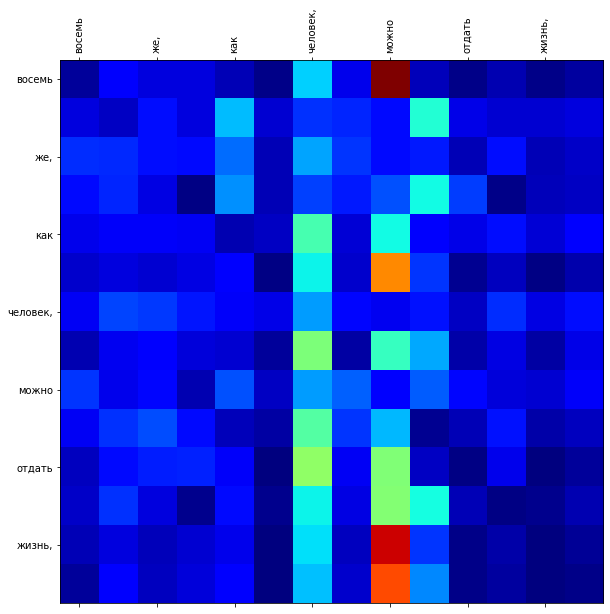

In [52]:
attention = de_bot_alignments[3][0, 7, :].numpy()
print(attention.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attention, cmap='jet')
ax.set_xticklabels([''] + prediction, rotation=90)
ax.set_yticklabels([''] + prediction)

### Examine Decoder's upper attention

(14, 24)


[Text(0, 0, ''),
 Text(0, 0, 'когда'),
 Text(0, 0, 'раздался'),
 Text(0, 0, 'из'),
 Text(0, 0, 'больницы,'),
 Text(0, 0, 'их'),
 Text(0, 0, 'не'),
 Text(0, 0, 'в'),
 Text(0, 0, 'которой')]

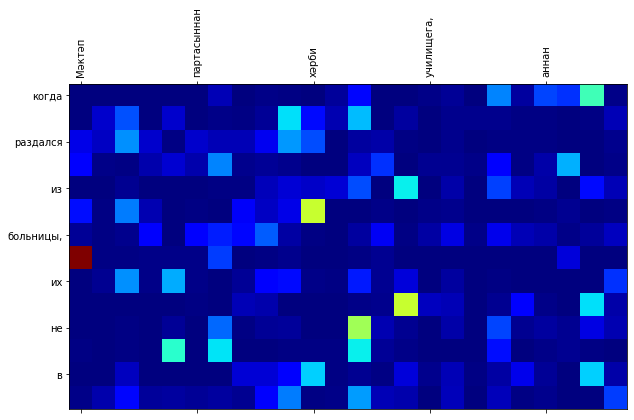

In [66]:
attention = de_mid_alignments[3][0, 2, :].numpy()
print(attention.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attention, cmap='jet')
ax.set_xticklabels([''] + source, rotation=90)
ax.set_yticklabels([''] + prediction)